## Worksheet 7

### Group 22 Eaton Heidegger and Shannon Schröder

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

### Poisson equation
#### N-body gravity solver

a)  Generate a model cluster of N stars (choose N as large as is feasible given your computational
 resources, e.g. N = 1000). Compute the 3D gravitational potential of the sampled cluster using
 the Green’s function approach. The analytical solution to the potential of a Plummer sphere
 is (in ‘N-body units’)

Greens function approach: 

If you have a linear differential equation of the form:
$L u(x) = f(x)$

where:

- $L$ is a linear differential operator (like the Laplacian $\nabla^2$ or a time derivative),
- $u(x)$ is the unknown function,
- $f(x)$ is a known source function,

then the Green’s function $G(x, x')$ is the solution to:

$L G(x, x') = \delta(x - x')$

where $\delta(x - x')$ is the Dirac delta function, representing a point source at position x'. 


(-10.0, 10.0)

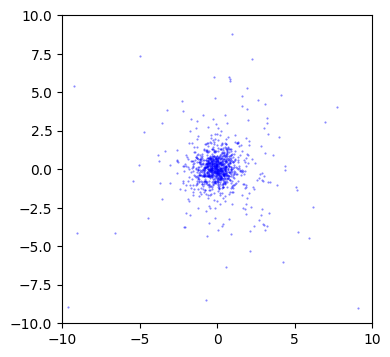

In [81]:
# Sample Plumber from provided Notebook :

# initialise the random number generator
rng = np.random.Generator(np.random.PCG64(seed=12345))

# Sample isotropic 3d vectors with a given modulus
def rand_vec3d( mod ):
    N = len(mod)
    phi = 2*np.pi*rng.random(size=N)
    theta = np.arccos( 2*rng.random(size=N)-1 )
    v3d = np.zeros( (N,3) )
    v3d[:,0] = mod * np.cos( phi ) * np.sin( theta )
    v3d[:,1] = mod * np.sin( phi ) * np.sin( theta )
    v3d[:,2] = mod * np.cos( theta )
    # subtract mean
    for i in range(3):
        v3d[:,i] -= np.mean(v3d[:,i])
    return v3d

# number of stars
N = 1000

# particle mass is 1/N
m = 1/N

# Sampling the mass, draw radii through inversion sampling from the cumulative mass M
U = rng.random(size=N)
rsamp = U**(1/3)/np.sqrt((1-U**(2/3)))

# create N empty 3D vectors
x3d = rand_vec3d( rsamp )
positions = x3d
# make a scatter plot of the stars
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(x3d[:,0], x3d[:,1], marker='.', s=1, c='b', alpha=0.5)
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)

Compute the 3D potential numerically via Green's function

The gravitational potential $\Phi(r)$ at a point $\vec{r}$ is: 

$\Phi(r) = - G \sum_{j \neq i}^N \frac{Gm}{|r_i - r_j|}$

In N body units: G = 1, m = 1/N (used WS 5)

The Green's functiton for gravitational potential is: 

$\Phi(r) = - \frac{1}{N} \sum_{j \neq i}^N \frac{1}{|r_i - r_j| + \epsilon^2}$

This is the numerical potential at position $r_i$, due to all other particles, softened with $\epsilon$ (which could be set to zero or a small value to avoid singularities). Because we exclude i = j to avoid singularities we can set $\epsilon$ to 0.


For the accelertion: $a(x) = - (\nabla \Phi)(x)$: 

$\vec{a}_j = - \nabla \Phi_j =- \frac{1}{N} \sum_{j \neq i}^N \frac{r_j-r_i}{|r_i - r_j|^3} $

In [ ]:
def compute_potential(positions):
    """
    Compute the gravitational potential and acceleration for a system of N particles
    using the Green's function approach in N-body units (G = 1, M = 1, m = 1/N).

    Parameters
    ----------
    positions : ndarray
        Array of shape (N, 3) containing 3D positions of the particles.

    Returns
    -------
    phi : ndarray
        Gravitational potential at each particle position (N,).
    acc : ndarray
        Acceleration vectors for each particle (N, 3).
    """
    N = positions.shape[0]
    m = 1/N

    # Compute pairwise position differences: shape (N, N, 3)
    dx = positions[:, np.newaxis, :] - positions[np.newaxis, :, :]  # r_i - r_j

    # Compute pairwise distances: shape (N, N)
    r = np.linalg.norm(dx, axis=2)

    # Avoid division by zero for self-interaction by setting diagonals to inf
    np.fill_diagonal(r, np.inf)
    # Distance matrix (NxN)
    #r_ij = cdist(x3d, x3d)
    # Potential: φ_j = -m * sum_i≠j 1/|r_j - r_i|
    phi = -1/N * np.sum(1 / r, axis=1)
    # Acceleration: a_j = -m * sum_i≠j (r_j - r_i) / |r_j - r_i|^3
    r3 = r**3
    acc = -m * np.sum(dx / r3[:, :, np.newaxis], axis=1)
    
    return phi, acc


Checkthat the potential computed for each star agrees on average (due to random sampling there will be fluctuations) with the expected gravitational potential at its location. 

In [85]:
# Compute numerical potential
phi_num, acc = compute_potential(x3d)

Compute the analytical Plummer potential: 

$\Phi_P(r) = - \frac{1}{\sqrt{1+r^2}}$

In [89]:
# Compute analytical Plummer potential at same positions
radii = np.linalg.norm(x3d, axis=1)
phi_analytic = -1 / np.sqrt(1 + radii**2)

In [90]:
# Compute mean and standard deviation of residuals
residuals = phi_num - phi_analytic
mean_diff = np.mean(residuals)
std_diff = np.std(residuals)
rel_error = np.mean(np.abs(residuals / phi_analytic))

print(f"Mean difference (Φ_numerical - Φ_analytic): {mean_diff:.4e}")
print(f"Std. deviation of difference: {std_diff:.4e}")
print(f"Mean relative error: {rel_error:.4%}")

Mean difference (Φ_numerical - Φ_analytic): -6.4295e-03
Std. deviation of difference: 1.9670e-02
Mean relative error: 2.3966%


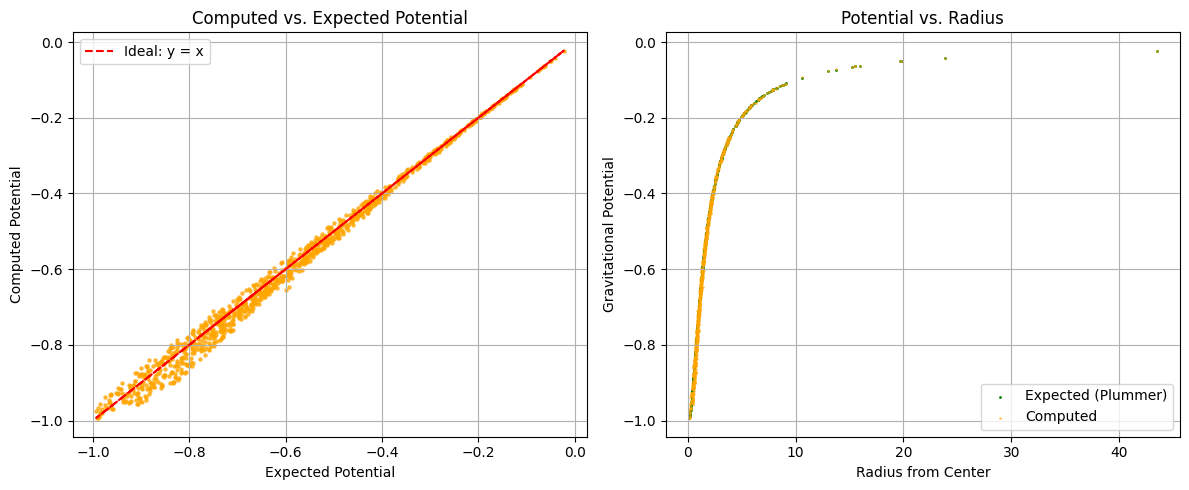

In [99]:
# Scatter plot: Computed vs. Expected potential
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(phi_analytic, phi_num, s=5,  alpha=0.7, c= 'orange')
plt.plot(phi_analytic, phi_analytic, color='red', linestyle='--', label='Ideal: y = x')
plt.xlabel('Expected Potential')
plt.ylabel('Computed Potential')
plt.title('Computed vs. Expected Potential')
plt.legend()
plt.grid(True)

# Scatter plot: Computed potential vs. radius
plt.subplot(1, 2, 2)
plt.scatter( radii, phi_analytic, s= 1, color='green', label='Expected (Plummer)')
plt.scatter(radii, phi_num, s=1, alpha=0.5, c= 'orange', label='Computed')

plt.xlabel('Radius from Center')
plt.ylabel('Gravitational Potential')
plt.title('Potential vs. Radius')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

On a 3D grid for vizualization: 

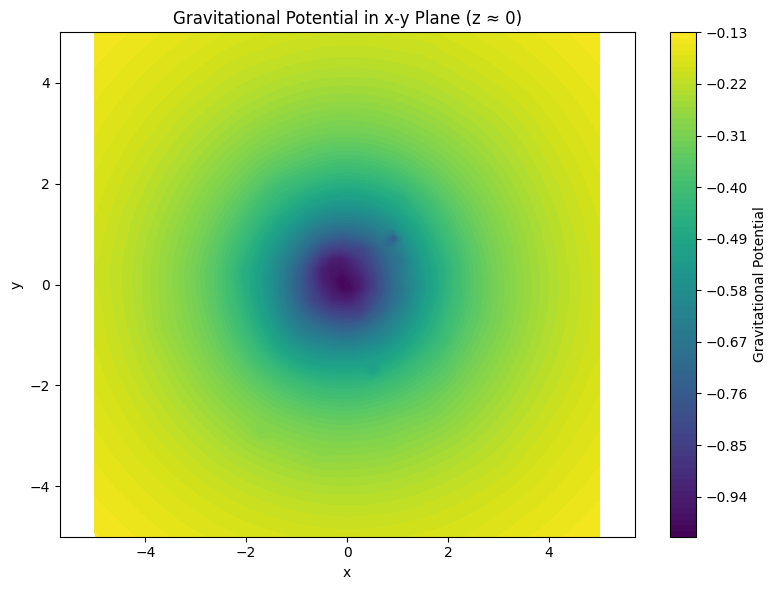

Total potential energy: -13.8643


In [104]:
def compute_potential_on_grid(positions, grid_range=5.0, grid_size=50, G=1.0, m=1.0/N):
    # Create 3D grid
    x = np.linspace(-grid_range, grid_range, grid_size)
    y = np.linspace(-grid_range, grid_range, grid_size)
    z = np.linspace(-grid_range, grid_range, grid_size)
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
    grid_points = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=1)

    # Compute potential at each grid point
    dists = cdist(grid_points, positions)
    phi_grid = -G * m * np.sum(1.0 / dists, axis=1)
    phi_grid = phi_grid.reshape((grid_size, grid_size, grid_size))

    return X, Y, Z, phi_grid

# Run the function to compute 3D potential field
Xg, Yg, Zg, phi_grid_3d = compute_potential_on_grid(x3d, grid_range=5.0, grid_size=50)

# Visualize a central slice in the x-y plane (z ≈ 0)
central_slice = phi_grid_3d[:, :, phi_grid_3d.shape[2] // 2]

plt.figure(figsize=(8, 6))
plt.contourf(Xg[:, :, 0], Yg[:, :, 0], central_slice, levels=100, cmap='viridis')
plt.colorbar(label='Gravitational Potential')
plt.title('Gravitational Potential in x-y Plane (z ≈ 0)')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.tight_layout()
plt.show()

U_total = 0.5 * np.sum(m * phi_grid_3d)
print(f"Total potential energy: {U_total:.4f}")